# Hydro Tasmania catchment rainfall


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_AGCD-CSIRO_r005_1900-2022_annual_hydro-tas.zarr.zip"
model_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_CAFE-c5-d60-pX-f6_19950501-20201101_annual_hydro-tas.zarr.zip"
model_add_bc_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_CAFE-c5-d60-pX-f6_19950501-20201101_annual_hydro-tas_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
model_mulc_bc_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_CAFE-c5-d60-pX-f6_19950501-20201101_annual_hydro-tas_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_add_bc_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_CAFE-c5-d60-pX-f6_1995-2020_annual_hydro-tas_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
similarity_mulc_bc_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_CAFE-c5-d60-pX-f6_1995-2020_annual_hydro-tas_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_CAFE-c5-d60-pX-f6_1995-2020_annual_hydro-tas_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/hydrotas/figures/independence-test_Rx14day_CAFE-c5-d60-pX-f6_19950501-20201101_annual_hydro-tas.png"
model_name = "CAFE"
min_lead = 0
region_name = "hydro-tas"
shape_file = "/home/599/dbi599/hydrotas/shapefiles/hydro-combined.shp"
file_list = "/home/599/dbi599/hydrotas/file_lists/CAFE_c5-d60-pX-f6_pr_files.txt"
nino_file = "/g/data/xv83/dbi599/hydrotas/data/nino34-anomaly_CAFE-c5-d60-pX-f6_19950501-20201101_base-1995-2020.nc"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
prmax = agcd_ds['pr'].values.max()
print(prmax)

277.08005


In [9]:
ranked_events = agcd_ds.to_dataframe().sort_values(['pr'], ascending=False)

## Model ensemble

### Region selection

In [10]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [11]:
first_file

'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip'

In [12]:
shapes = gp.read_file(shape_file)

In [13]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [14]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-47, -37],
    lon_bnds=[141, 152],
    shapefile=shape_file,
    shape_overlap=0.05,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

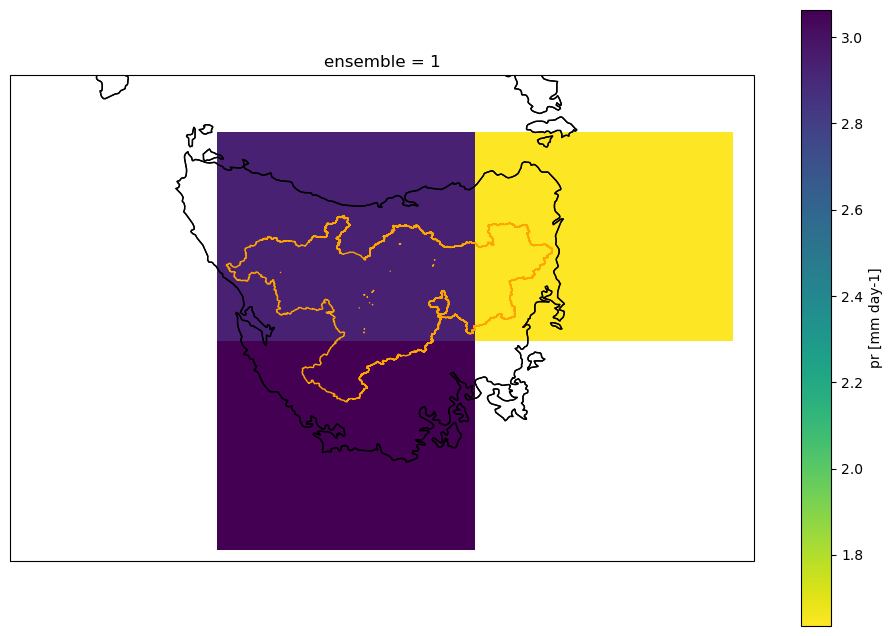

In [21]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.set_xlim([143, 150.2])
ax.set_ylim([-44.6, -39.9])
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [10]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [11]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 96, init_date: 52, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
    event_time  (init_date, lead_time, ensemble) <U28 dask.array<chunksize=(52, 11, 96), meta=np.ndarray>
  * init_date   (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 52), meta=np.ndarray>
Data variables:
    pr          (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 11, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Wed Apr 05 12:31:49 2023: /g/data/xv83/dbi599/miniconda3/envs...
    title:      AccessOcean-AM2

### Independence testing

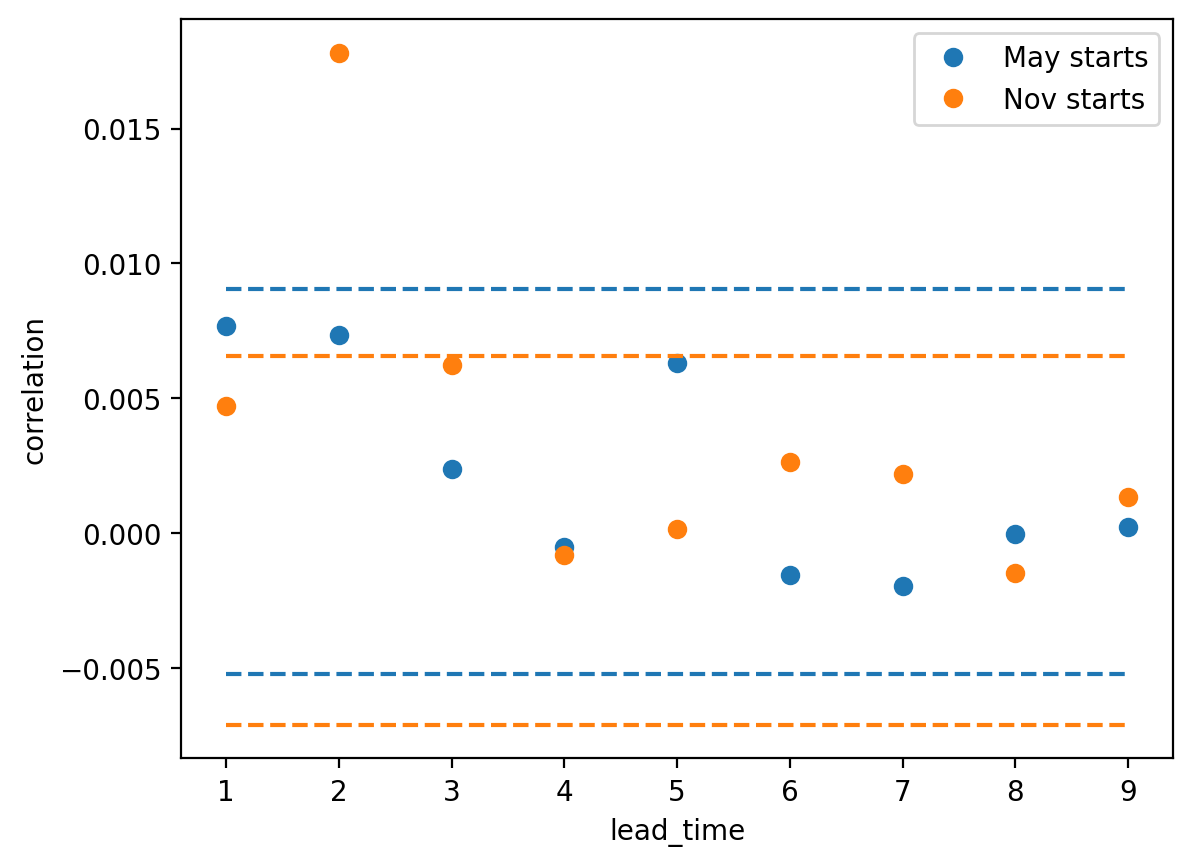

In [12]:
Image(filename=independence_plot)

In [13]:
print(min_lead)

0


In [14]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [15]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [16]:
model_da_stacked.shape

(44928,)

In [17]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [18]:
model_add_bc_da_stacked.shape

(44928,)

In [19]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [20]:
model_mulc_bc_da_stacked.shape

(44928,)

### Stability testing

In [62]:
def plot_dist_by_lead(sample_ds, model_name):
    """Plot distribution curve by lead time"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    lead_times = np.unique(model_da_stacked['lead_time'].values)
    colors = iter(plt.cm.BuPu(np.linspace(0.3, 1, len(lead_times))))

    for lead in lead_times:
        ds_selection = sample_ds.sel({'lead_time': lead})
        ds_selection = ds_selection.dropna('sample')
        color = next(colors)
        lead_df = pd.DataFrame(ds_selection.values)
        n_values = len(ds_selection)
        sns.kdeplot(lead_df[0], ax=ax, color=color, label=f'lead time {lead} ({n_values} samples)')

    ax.grid(True)
    ax.set_xlim(40, 175)    
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('Rx14day precipitation (mm)')
    ax.legend()
    plt.show()

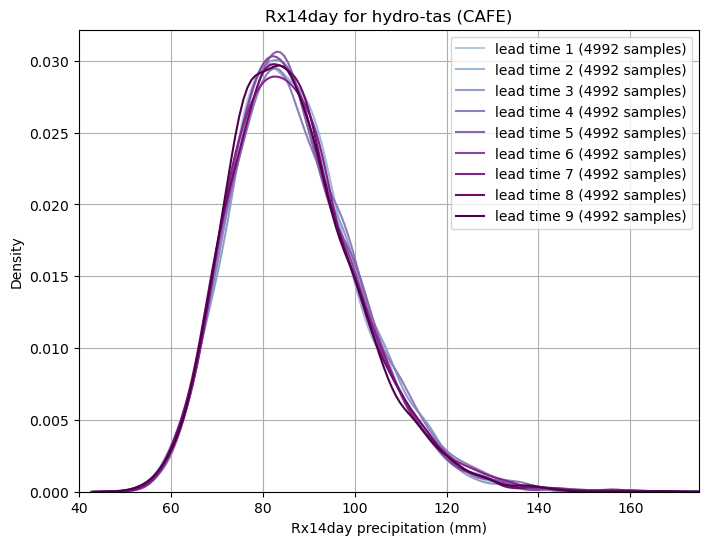

In [63]:
plot_dist_by_lead(model_da_stacked, model_name)

In [64]:
def return_curve(data, method):
    """Return x and y data for a return period curve.
    
    Args:
      data: xarray DataArray
      method : {'gev', 'empirical'}
          Fit a GEV or not to data
    """
    
    if method == 'gev':
        return_periods = np.logspace(0, 4, num=10000)
        probabilities = 1. / return_periods
        shape, loc, scale = indices.fit_gev(data, generate_estimates=True)
        return_values = gev.isf(probabilities, shape, loc, scale)
    elif method == 'empirical':
        return_values = np.sort(data, axis=None)[::-1]
        return_periods = len(data) / np.arange(1.0, len(data) + 1.0)
        
    return return_periods, return_values

In [65]:
def plot_return_by_lead(sample_ds, model_name, uncertainty=False):
    """Plot return period curve by lead time"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    lead_times = np.unique(model_da_stacked['lead_time'].values)
    colors = iter(plt.cm.BuPu(np.linspace(0.3, 1, len(lead_times))))

    for lead in lead_times:
        ds_selection = sample_ds.sel({'lead_time': lead})
        ds_selection = ds_selection.dropna('sample')
        return_periods, return_values = return_curve(ds_selection, method='empirical')
        n_values = len(ds_selection)
        label = f'lead time {lead} ({n_values} samples)'
        color = next(colors)
        ax.plot(return_periods, return_values, label=label, color=color)
    
    if uncertainty:
        random_return_values = []
        for i in range(1000):
            random_sample = np.random.choice(sample_ds, n_values)
            return_periods, return_values = return_curve(random_sample, method='empirical')
            random_return_values.append(return_values)
        random_return_values_stacked = np.stack(random_return_values)
        upper_ci = np.percentile(random_return_values_stacked, 97.5, axis=0)
        lower_ci = np.percentile(random_return_values_stacked, 2.5, axis=0)
        ax.fill_between(return_periods, upper_ci, lower_ci, label='95% confidence interval', color='0.5', alpha=0.1)
    
    ax.grid()
    ax.set_xscale('log')
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx14day precipitation (mm)')
    ax.legend()
    plt.show()

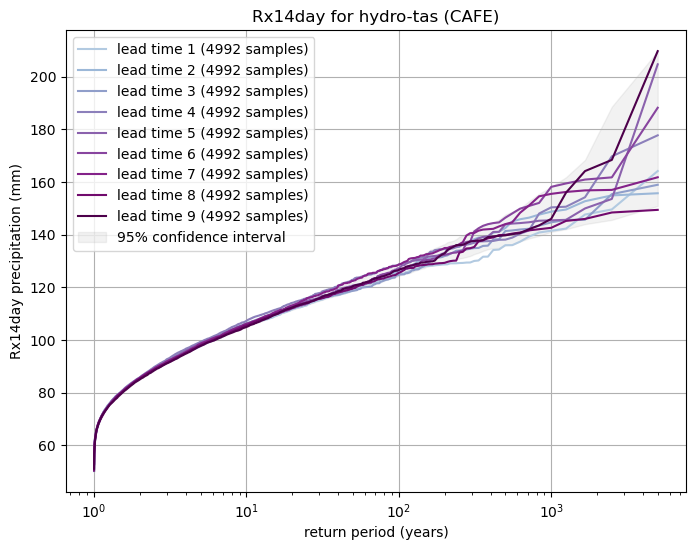

In [66]:
plot_return_by_lead(model_da_stacked, model_name, uncertainty=True)

### Bias correction and similarity testing

In [21]:
model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values, generate_estimates=True)

In [22]:
model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = indices.fit_gev(
    model_add_bc_da_stacked.values,
    generate_estimates=True)

In [23]:
model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = indices.fit_gev(
    model_mulc_bc_da_stacked.values,
    generate_estimates=True
)

In [24]:
agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)

In [23]:
def plot_distributions(include_additive=False):
    """Plot various distributions"""

    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, 500)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds['pr'].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)

    model_mulc_bc_ds['pr'].plot.hist(
        bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
    )
    model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
    plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)

    agcd_ds['pr'].plot.hist(
        bins=50, density=True, label='AGCD', facecolor='tab:gray', alpha=0.7
    )
    agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
    plt.plot(gev_xvals, agcd_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Rx14day for {region_name} ({model_name})')
    plt.xlim(50, 300)
    plt.legend()
#    if not include_additive:
#        outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx14day_histogram_{model_name}_{region_name}.png'
#        print(outfile)
#        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

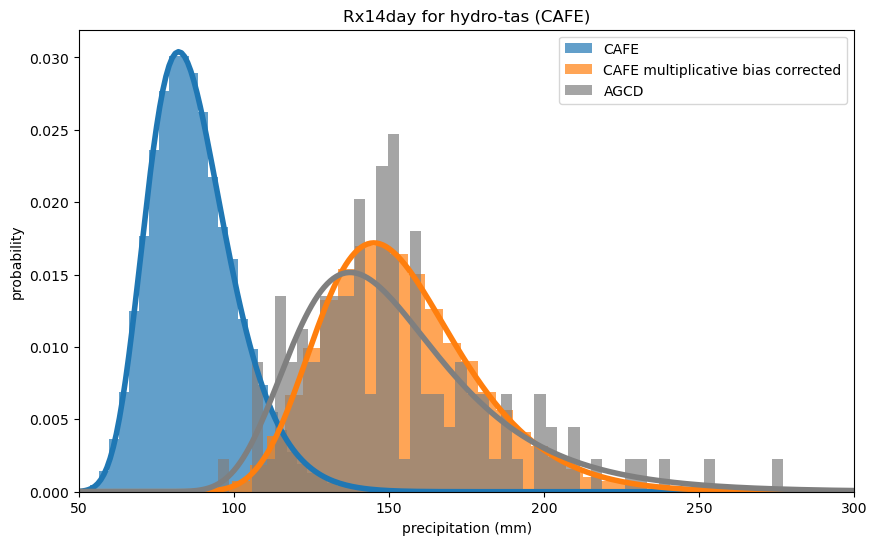

In [24]:
plot_distributions()

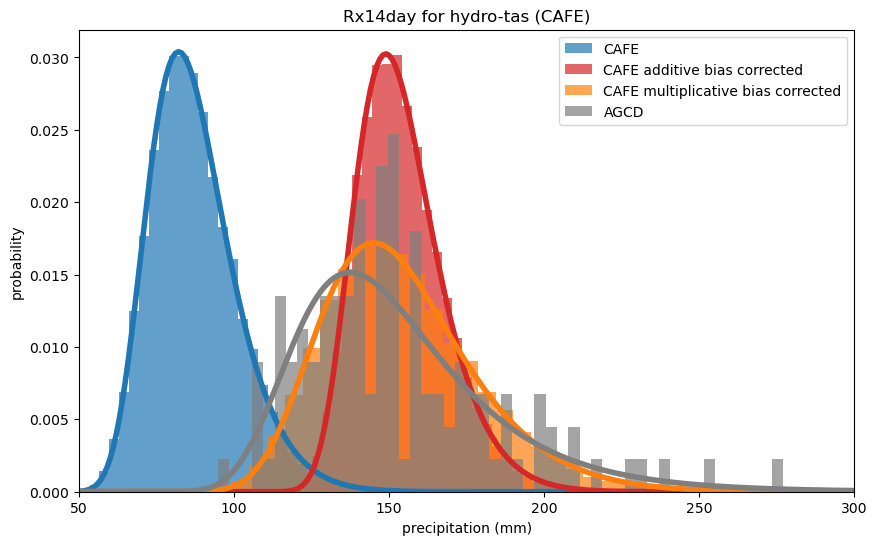

In [25]:
plot_distributions(include_additive=True)

In [74]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

raw data shape parameter: 0.081
raw data location parameter: 81.068
raw data scale parameter: 12.143


In [75]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

additive corrected shape parameter: 0.083
additive corrected location parameter: 147.873
additive corrected scale parameter: 12.204


In [76]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

multiplicative corrected shape parameter: 0.081
multiplicative corrected location parameter: 143.220
multiplicative corrected scale parameter: 21.474


We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [77]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [78]:
similarity_raw_ds['ks_pval'].values

array([1.1138106e-30, 1.0541266e-29, 2.7382637e-29, 1.6213222e-27,
       4.6528466e-29, 1.2107632e-29, 4.0794025e-29, 1.2107632e-29,
       3.9129265e-30], dtype=float32)

In [79]:
similarity_raw_ds['ad_pval'].values

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
      dtype=float32)

In [80]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [81]:
similarity_add_bias_ds['ks_pval'].values

array([0.0345086 , 0.03270741, 0.01637517, 0.01972765, 0.0088358 ,
       0.00461372, 0.01318454, 0.00557748, 0.01318454], dtype=float32)

In [82]:
similarity_add_bias_ds['ad_pval'].values

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
      dtype=float32)

In [83]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [84]:
similarity_mulc_bias_ds['ks_pval'].values

array([0.5271539 , 0.5026302 , 0.44597077, 0.4505617 , 0.3858716 ,
       0.32221037, 0.40293548, 0.34260094, 0.40582272], dtype=float32)

In [85]:
similarity_mulc_bias_ds['ad_pval'].values

array([0.25      , 0.25      , 0.23171142, 0.25      , 0.15426067,
       0.11880034, 0.18610066, 0.1267451 , 0.20020232], dtype=float32)

### Return curves

In [86]:
def plot_return(sample_ds, model_name, method, outfile=None):
    """Plot return period curve.
    
    method: {'gev', 'empirical'}  
    """
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    return_periods, return_values = return_curve(sample_ds, method)
    ax.plot(return_periods, return_values)
    ax.set_xscale('log')
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx14day precipitation (mm)')
    ax.axhline(prmax, color='0.5', linestyle='--')
    ax.grid()
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [87]:
def plot_return_by_decade(sample_ds, model_name, method, uncertainty=False):
    """Plot return period curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        return_periods, return_values = return_curve(ds_selection, method)
        n_years = len(ds_selection)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(return_periods, return_values, label=label, color=color)
    
    if uncertainty:
        random_return_values = []
        for i in range(1000):
            random_sample = np.random.choice(sample_ds, n_years)
            return_periods, return_values = return_curve(random_sample, method)
            random_return_values.append(return_values)
        random_return_values_stacked = np.stack(random_return_values)
        upper_ci = np.percentile(random_return_values_stacked, 97.5, axis=0)
        lower_ci = np.percentile(random_return_values_stacked, 2.5, axis=0)
        ax.fill_between(return_periods, upper_ci, lower_ci, label='95% confidence interval', color='0.5', alpha=0.2)
    
    ax.grid()
    ax.set_xscale('log')
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx14day precipitation (mm)')
    ax.legend()
    ax.axhline(prmax, color='0.5', linestyle='--')
#    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
#    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()
#    print(outfile)

In [26]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

#### Multiplicative bias corrected data

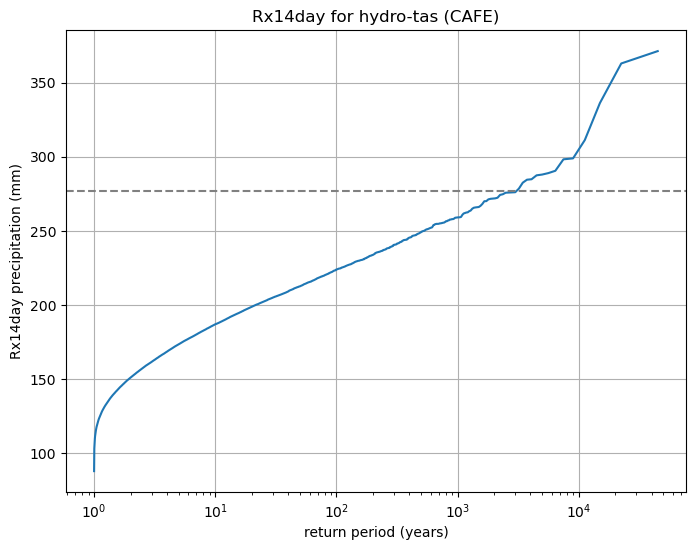

In [89]:
plot_return(model_mulc_bc_da_stacked, model_name, method='empirical')

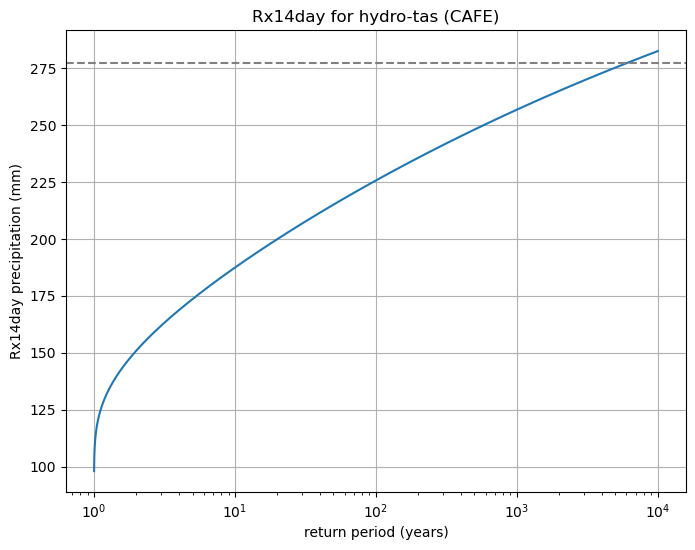

In [90]:
plot_return(model_mulc_bc_da_stacked, model_name, method='gev')

In [91]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, prmax, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

MULTIPLICATIVE BIAS CORRECTED DATA
0 events in 44928 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:163: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [27]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
for rank in range(5):
    event = float(ranked_events.iloc[[rank]]['pr'].values)
    date = ranked_events.iloc[[rank]]['event_time'].values[0]
    print(f'{date}: {event:.1f}mm')
    gev_event_likelihood(event, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

MULTIPLICATIVE BIAS CORRECTED GEV
1960-04-28: 277.1mm
99.98% percentile
5964 year return period

1923-05-24: 254.0mm
99.88% percentile
802 year return period

1947-06-24: 238.6mm
99.60% percentile
248 year return period

1929-04-14: 231.4mm
99.33% percentile
149 year return period

1958-05-29: 228.8mm
99.19% percentile
124 year return period



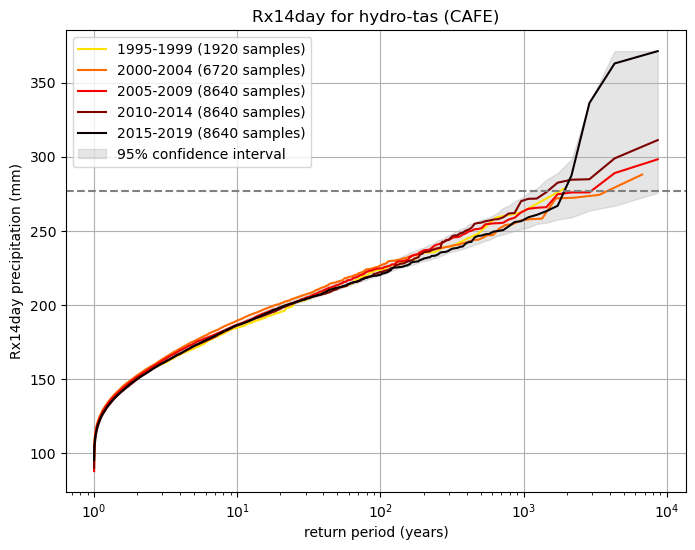

In [94]:
plot_return_by_decade(model_mulc_bc_da_stacked, model_name, method='empirical', uncertainty=True)

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


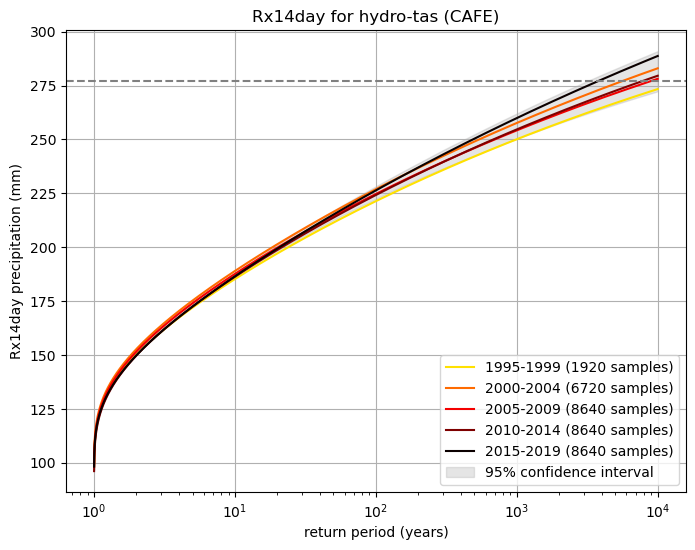

In [93]:
plot_return_by_decade(model_mulc_bc_da_stacked, model_name, method='gev', uncertainty=True)

#### Raw data

In [95]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, prmax, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 44928 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:163: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [96]:
print('RAW GEV')
gev_event_likelihood(prmax, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
inf year return period



/jobfs/78728376.gadi-pbs/ipykernel_1793678/2330044597.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  return_period = 1. / probability


### Seasonality

In [28]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [29]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

In [30]:
model_df['month'] = event_months
monthly_ave = model_df.groupby('month').mean(['pr'])

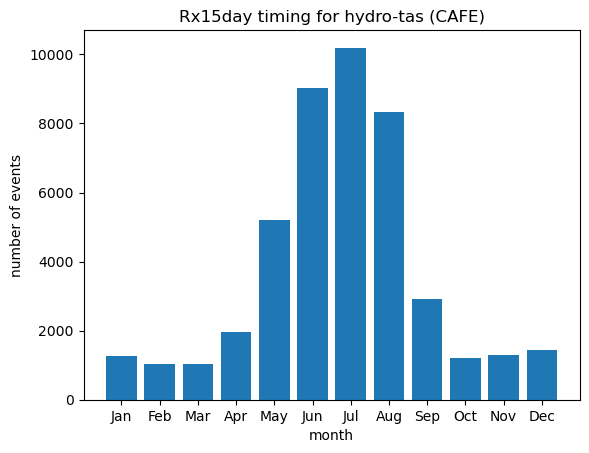

In [99]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

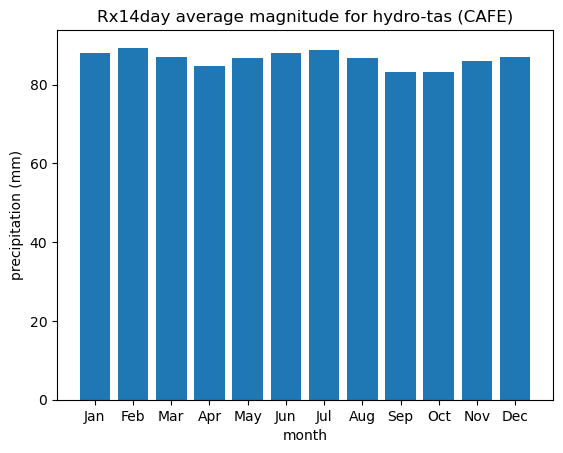

In [31]:
months = np.arange(1, 13)
averages = monthly_ave['pr'].values

plt.bar(months, averages)
plt.title(f'Rx14day average magnitude for {region_name} ({model_name})')
plt.ylabel('precipitation (mm)')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
plt.show()

### Relationship with ENSO

In [100]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (init_date: 52, lead_time: 120, ensemble: 96)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * init_date  (init_date) <U6 '199505' '199511' '199605' ... '202005' '202011'
    time       (lead_time, init_date) object dask.array<chunksize=(120, 52), meta=np.ndarray>
Data variables:
    tos        (init_date, lead_time, ensemble) float32 dask.array<chunksize=(52, 120, 96), meta=np.ndarray>
Attributes:
    history:  Wed Apr 05 13:29:49 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [101]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [102]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


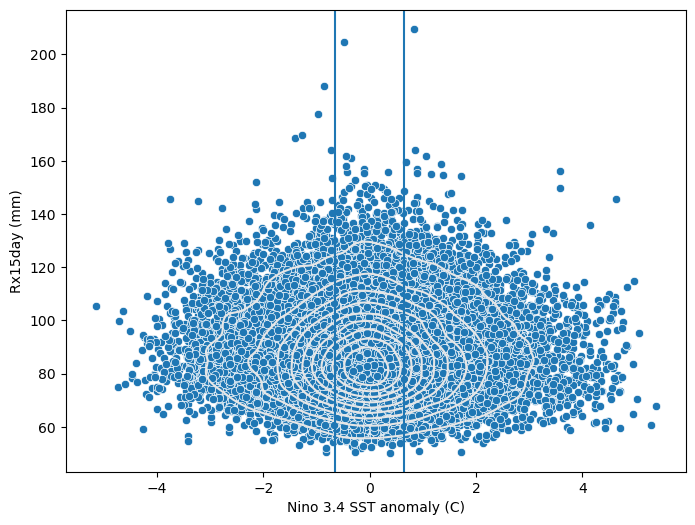

In [103]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [104]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [105]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

,,,event_time,time,ensemble,init_date,lead_time,pr,nino34
ensemble,init_date,lead_time,,,,,,,
17,2008-05-01 00:00:00,9,2017-02-23,2017-05-01 12:00:00,17,2008-05-01 00:00:00,9,209.739163,0.829205
25,2012-05-01 00:00:00,5,2017-03-02,2017-05-01 12:00:00,25,2012-05-01 00:00:00,5,204.725976,-0.476021
52,2010-05-01 00:00:00,6,2016-06-28,2016-05-01 12:00:00,52,2010-05-01 00:00:00,6,188.226569,-0.854090
88,2010-05-01 00:00:00,4,2014-03-09,2014-05-01 12:00:00,88,2010-05-01 00:00:00,4,177.752721,-0.963984
94,2004-11-01 00:00:00,4,2008-01-22,2008-11-01 12:00:00,94,2004-11-01 00:00:00,4,169.766766,-1.273998
1,2002-11-01 00:00:00,9,2011-06-09,2011-11-01 12:00:00,1,2002-11-01 00:00:00,9,168.407451,-1.412014
3,2003-05-01 00:00:00,1,2004-06-21,2004-05-01 12:00:00,3,2003-05-01 00:00:00,1,164.180340,-0.722469
41,2018-05-01 00:00:00,9,2027-12-10,2027-05-01 12:00:00,41,2018-05-01 00:00:00,9,164.161560,0.854233
39,2006-11-01 00:00:00,7,2013-01-21,2013-11-01 12:00:00,39,2006-11-01 00:00:00,7,161.815154,-0.448502


In [106]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

,init_date,lead_time,ensemble,event_time,time,pr
23248,2008-05-01 00:00:00,9,17,2017-02-23,2017-05-01 12:00:00,276.750734
29784,2012-05-01 00:00:00,5,25,2017-03-02,2017-05-01 12:00:00,272.227102
26451,2010-05-01 00:00:00,6,52,2016-06-28,2016-05-01 12:00:00,256.560523
26295,2010-05-01 00:00:00,4,88,2014-03-09,2014-05-01 12:00:00,243.744333
16797,2004-11-01 00:00:00,4,94,2008-01-22,2008-11-01 12:00:00,236.062311
13728,2002-11-01 00:00:00,9,1,2011-06-09,2011-11-01 12:00:00,235.666620
40552,2018-05-01 00:00:00,9,41,2027-12-10,2027-05-01 12:00:00,231.173131
12617,2002-05-01 00:00:00,6,42,2008-07-05,2008-05-01 12:00:00,230.114397
13826,2003-05-01 00:00:00,1,3,2004-06-21,2004-05-01 12:00:00,229.596136
26433,2010-05-01 00:00:00,6,34,2016-11-21,2016-05-01 12:00:00,229.275005


In [107]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

,init_date,lead_time,ensemble,event_time,time,pr
23248,2008-05-01 00:00:00,9,17,2017-02-23,2017-05-01 12:00:00,371.232862
29784,2012-05-01 00:00:00,5,25,2017-03-02,2017-05-01 12:00:00,362.914136
26451,2010-05-01 00:00:00,6,52,2016-06-28,2016-05-01 12:00:00,336.237127
26295,2010-05-01 00:00:00,4,88,2014-03-09,2014-05-01 12:00:00,311.250023
13728,2002-11-01 00:00:00,9,1,2011-06-09,2011-11-01 12:00:00,298.927237
16797,2004-11-01 00:00:00,4,94,2008-01-22,2008-11-01 12:00:00,298.298189
40552,2018-05-01 00:00:00,9,41,2027-12-10,2027-05-01 12:00:00,290.561690
12617,2002-05-01 00:00:00,6,42,2008-07-05,2008-05-01 12:00:00,288.995288
13826,2003-05-01 00:00:00,1,3,2004-06-21,2004-05-01 12:00:00,288.016396
26433,2010-05-01 00:00:00,6,34,2016-11-21,2016-05-01 12:00:00,287.495846


20080501 (2017-02-23), ensemble:17, 209.73916278794184mm


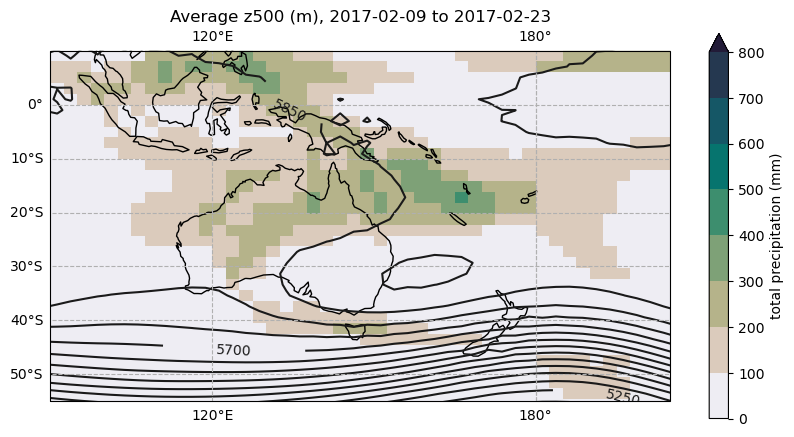

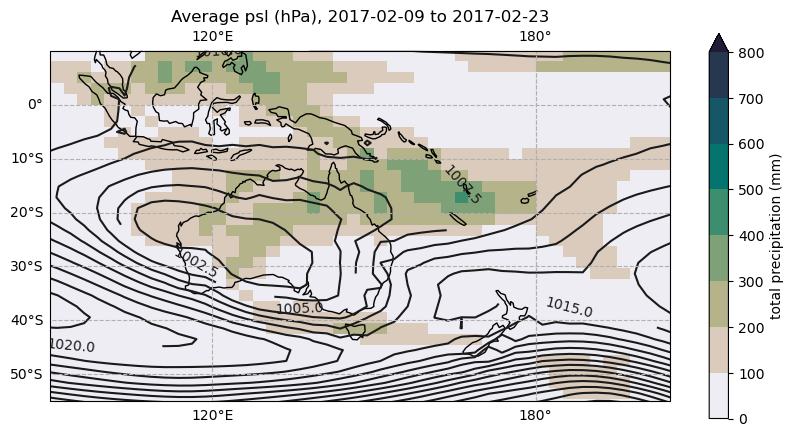

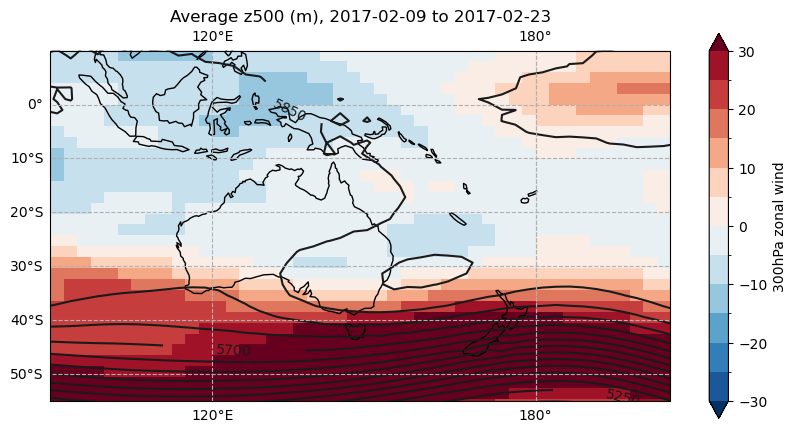

20120501 (2017-03-02), ensemble:25, 204.7259760061634mm


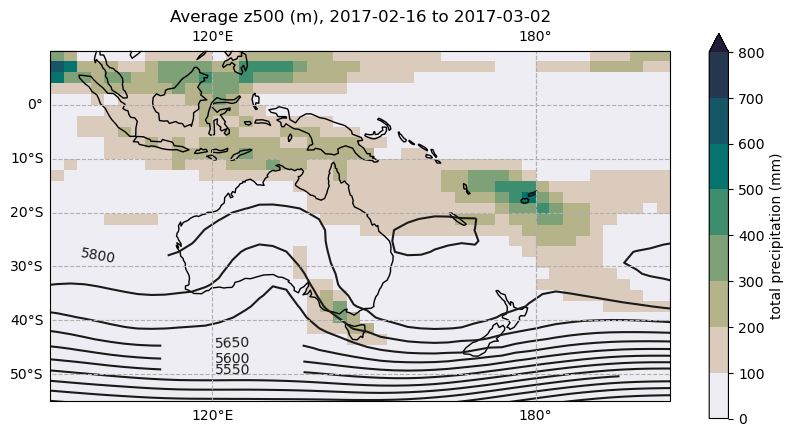

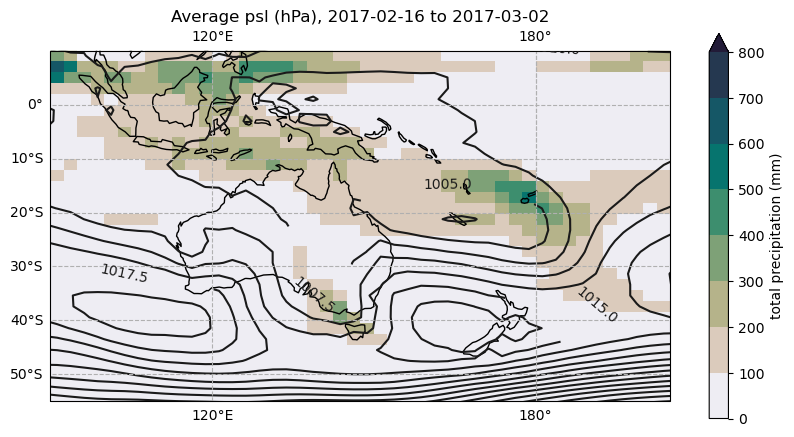

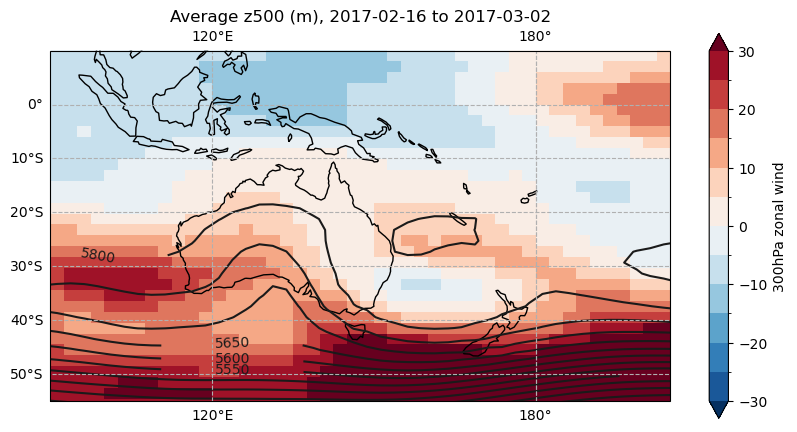

20100501 (2016-06-28), ensemble:52, 188.22656887620698mm


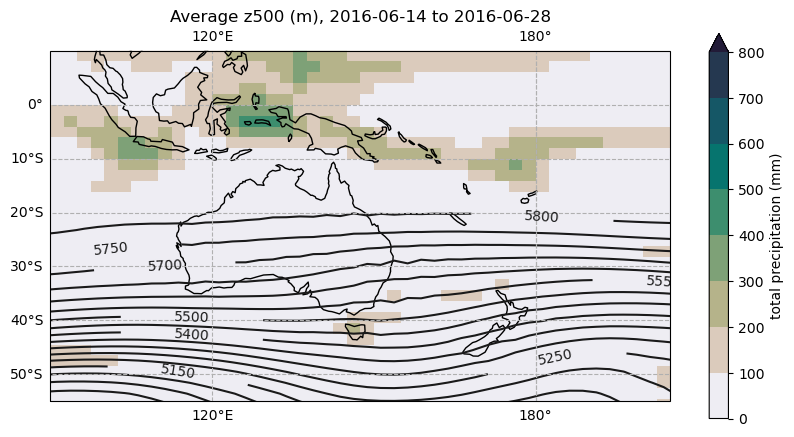

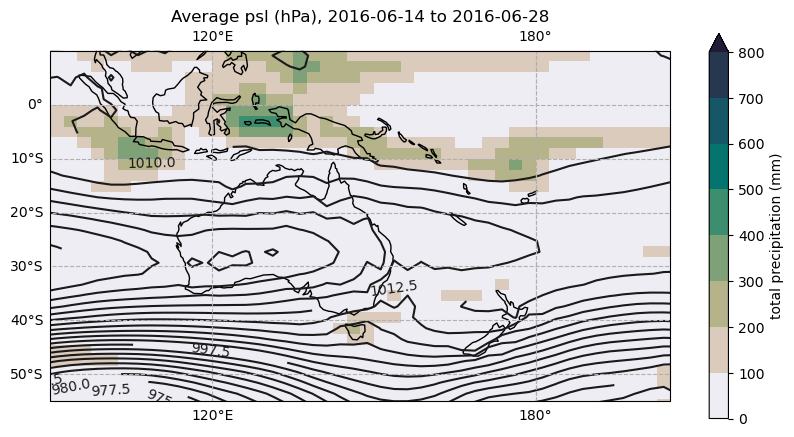

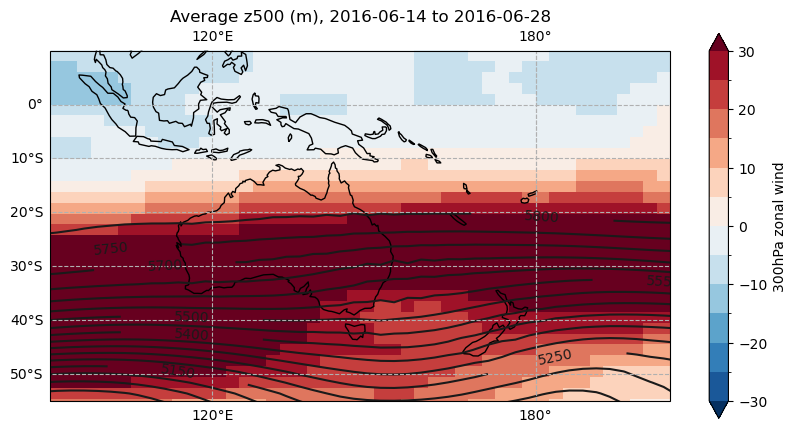

20100501 (2014-03-09), ensemble:88, 177.75272118160936mm


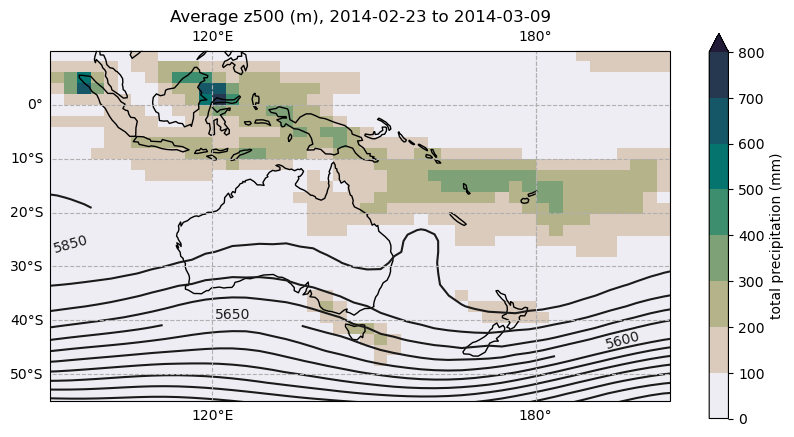

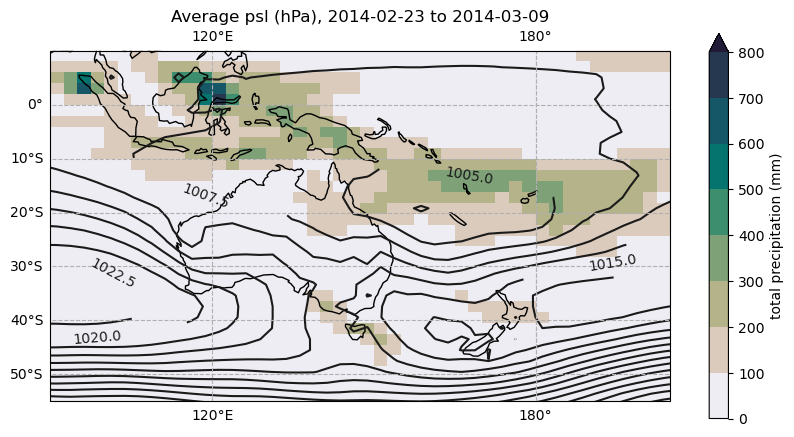

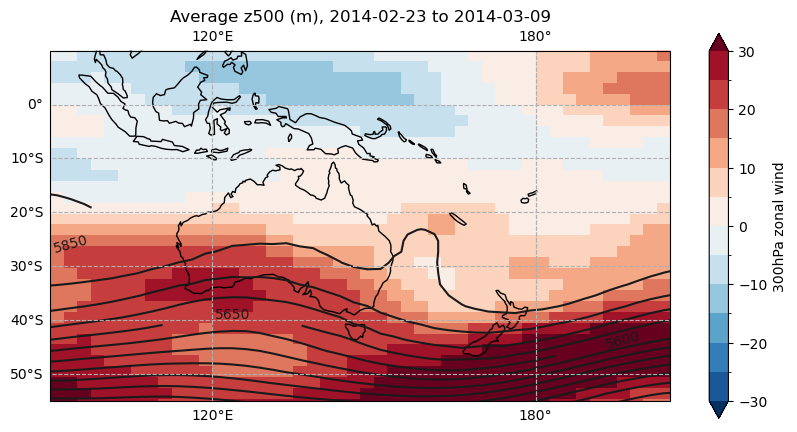

In [108]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = row['init_date'].strftime('%Y%m%d')
    ensemble = row['ensemble']
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble:{ensemble}, {rx_value}mm')
    
    atmos_file = f'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-{init_date}/atmos_isobaric_daily.zarr.zip'
    atmos_ds = fileio.open_dataset(
        atmos_file,
        metadata_file='/home/599/dbi599/unseen/config/dataset_cafe_daily.yml',
        variables=['h500', 'slp', 'pr', 'ucomp'],
    )
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    z500_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['h500']
    pr_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['pr']
    pr_da = general_utils.convert_units(pr_da, 'mm d-1')
    psl_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['slp']
    ua300_da = atmos_ds.sel({'ensemble': ensemble, 'level': 300, 'time': slice(start_date, end_date)})['ucomp']

    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
    plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')